In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers torch sentencepiece underthesea openpyxl

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv("/content/df_train_clean.csv")
df_dev   = pd.read_csv("/content/df_dev_clean.csv")
df_test  = pd.read_csv("/content/df_test_clean.csv")

for df in (df_train, df_dev, df_test):
    if 'label' not in df.columns:
        if 'Emotion' in df.columns:
            df['label'] = df['Emotion']
        elif 'label_id' in df.columns:
            df['label'] = df['label_id']

for df in (df_train, df_dev, df_test):
    assert 'content_clean' in df.columns
    df['content_clean'] = df['content_clean'].fillna('').astype(str)

In [ ]:
# Xác định các nhãn và chuẩn hóa
emotions = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Fear', 'Surprise', 'Other']
label2id = {e:i for i, e in enumerate(emotions)}
id2label = {i:e for i, e in enumerate(emotions)}

# Đảm bảo đúng mapping
for df in (df_train, df_dev, df_test):
    df['label_id'] = df['label'].map(label2id)


In [ ]:
emotions = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Fear', 'Surprise', 'Other']
label2id = {e:i for i, e in enumerate(emotions)}
id2label = {i:e for i, e in enumerate(emotions)}
for df in (df_train, df_dev, df_test):
    df['label_id'] = df['label'].map(label2id)

In [ ]:
classes = np.arange(len(emotions))
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df_train["label_id"].to_numpy()
)
class_weights = torch.tensor(weights, dtype=torch.float)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(
            txt,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [ ]:
MODEL_NAME = "vinai/phobert-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)
model      = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(emotions)
)

train_ds = SentimentDataset(
    df_train["content_clean"].tolist(),
    df_train["label_id"].tolist(),
    tokenizer
)
dev_ds = SentimentDataset(
    df_dev["content_clean"].tolist(),
    df_dev["label_id"].tolist(),
    tokenizer
)
test_ds = SentimentDataset(
    df_test["content_clean"].tolist(),
    df_test["label_id"].tolist(),
    tokenizer
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        if return_outputs:
            return loss, outputs
        return loss

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":        accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro":    recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro":        f1_score(labels, preds, average="macro"),
        "f1_micro":        f1_score(labels, preds, average="micro")
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./phobert_weighted",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    save_total_limit=1,
    do_eval=True,
    report_to="none"
)

In [ ]:
trainer = WeightedTrainer(
    model            = model,
    args             = training_args,
    train_dataset    = train_ds,
    eval_dataset     = dev_ds,
    compute_metrics  = compute_metrics
)

In [ ]:
  trainer.train()

Step,Training Loss
100,1.874500
200,1.617300
300,1.380200
400,1.236500
500,1.125000
600,1.125200
700,1.021200
800,0.792300
900,0.816100
1000,0.827100


TrainOutput(global_step=3470, training_loss=0.5781890143578609, metrics={'train_runtime': 1413.3067, 'train_samples_per_second': 39.255, 'train_steps_per_second': 2.455, 'total_flos': 3649514168064000.0, 'train_loss': 0.5781890143578609, 'epoch': 10.0})

In [ ]:
save_path = '/content/drive/MyDrive/phobert_finetuned'
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/phobert_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/phobert_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/phobert_finetuned/vocab.txt',
 '/content/drive/MyDrive/phobert_finetuned/bpe.codes',
 '/content/drive/MyDrive/phobert_finetuned/added_tokens.json')

In [ ]:
def evaluate_and_plot(split_name, ds, df, emotions):
    print(f"\n=== Evaluation on {split_name} ===")
    metrics = trainer.evaluate(eval_dataset=ds)
    print("Accuracy      :", metrics["eval_accuracy"])
    print("F1-Macro      :", metrics["eval_f1_macro"])
    preds = trainer.predict(ds).predictions.argmax(-1)
    print("\nClassification Report:")
    print(classification_report(df["label_id"], preds, target_names=emotions, zero_division=0, digits=4))
    cm = confusion_matrix(df["label_id"], preds, labels=np.arange(len(emotions)))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=emotions, yticklabels=emotions)
    plt.title(f"PhoBERT Confusion ({split_name})")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()


=== Evaluation on Dev ===


Accuracy      : 0.6180758017492711
F1-Macro      : 0.5889729881787955

Classification Report:
              precision    recall  f1-score   support

   Enjoyment     0.7574    0.7150    0.7356       214
     Disgust     0.6127    0.6444    0.6282       135
     Sadness     0.4959    0.6977    0.5797        86
       Anger     0.5556    0.5102    0.5319        49
        Fear     0.4571    0.5161    0.4848        31
    Surprise     0.6111    0.7333    0.6667        30
       Other     0.5810    0.4326    0.4959       141

    accuracy                         0.6181       686
   macro avg     0.5815    0.6071    0.5890       686
weighted avg     0.6255    0.6181    0.6168       686



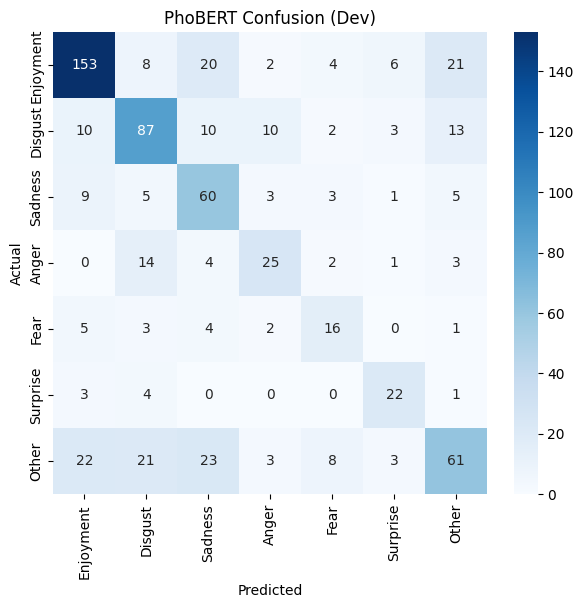


=== Evaluation on Test ===


Accuracy      : 0.6176046176046176
F1-Macro      : 0.608927143458709

Classification Report:
              precision    recall  f1-score   support

   Enjoyment     0.7222    0.6736    0.6971       193
     Disgust     0.5746    0.5833    0.5789       132
     Sadness     0.5985    0.6810    0.6371       116
       Anger     0.4545    0.5000    0.4762        40
        Fear     0.7000    0.7609    0.7292        46
    Surprise     0.6000    0.6486    0.6234        37
       Other     0.5575    0.4884    0.5207       129

    accuracy                         0.6176       693
   macro avg     0.6011    0.6194    0.6089       693
weighted avg     0.6193    0.6176    0.6171       693



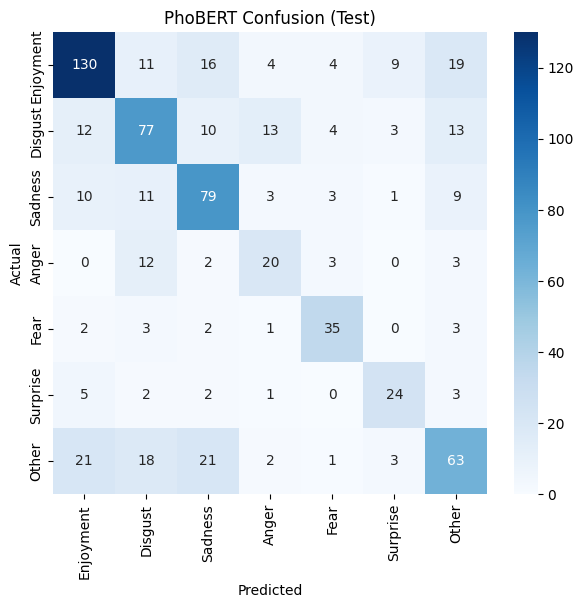

In [ ]:
evaluate_and_plot("Dev", dev_ds, df_dev, emotions)
evaluate_and_plot("Test", test_ds, df_test, emotions)